In [1]:
import warnings
warnings.filterwarnings('ignore')
import json

from qiskit.tools.jupyter import *
from qiskit import IBMQ
from qiskit import pulse                  # This is where we access all of our Pulse features!
from qiskit.circuit import Parameter      # This is Parameter Class for variable parameters.
from qiskit.circuit import QuantumCircuit, Gate
from qiskit import transpile, schedule, assemble
from qiskit.tools.monitor import job_monitor

import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl

from scipy.optimize import curve_fit

In [2]:
import sys, os
sys.path.insert(0, '../..')
from utils.circuit_utils import get_closest_multiple_of, get_closest_multiple_of_16
from utils.job_utils import get_job_data, save_job, load_job
from utils.result_utils import baseline_remove, fit_function, single_qubit_count
from utils.higher_energy_states.pulse_gate import Sched
from utils.higher_energy_states.state_prep import gen_circ

In [3]:
with open(r"../provider.json", "r") as f:
    credential = json.load(f)

IBMQ.load_account()
provider = IBMQ.get_provider(hub = credential["hub"], group = credential["group"], project = credential["project"])
backend = provider.get_backend("ibm_lagos")

In [4]:
sched = Sched(backend)
sched.load_gate_data(os.path.join("..", "data", f"{backend.configuration().backend_name}_gate_data.json"))
sched.create_scheds()

In [5]:
num_qubit = backend.configuration().n_qubits
acquire_alignment = backend.configuration().timing_constraints['acquire_alignment']
granularity = backend.configuration().timing_constraints['granularity']
pulse_alignment = backend.configuration().timing_constraints['pulse_alignment']
dt = backend.configuration().dt
basis_gates = backend.configuration().basis_gates
basis_gates

['id', 'rz', 'sx', 'x', 'cx', 'reset']

# Helper Fcuntions

In [6]:
colors = ['grey', 'green', 'crimson', 'cornflowerblue']

In [7]:
x_gate = QuantumCircuit(1)
x_gate.x(0)
x_duration = schedule(x_gate, backend).duration

def gen_circ(circ_type, num_reset, add_secure_reset = False, reset_qubit_list = None, add_delay = False, measure = True):
    qubit_list = list(range(num_qubit))

    x12_duration = 160
    x23_duration = 160
    
    circ = QuantumCircuit(num_qubit)
    if circ_type == -1:
        pass
    elif circ_type == 0:
        if add_delay:
            circ.delay(x_duration + x12_duration + x23_duration, qubit_list)
    elif circ_type == 1:
        if add_delay:
            circ.delay(x12_duration + x23_duration, qubit_list)
        circ.x(qubit_list)
    elif circ_type == 2:
        if add_delay:
            circ.delay(x23_duration, qubit_list)
        circ.x(qubit_list)
        x12_gate = Gate("x12_gate", 1, [])
        for qubit in qubit_list:
            circ.append(x12_gate, [qubit])
            circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
    elif circ_type == 3:
        circ.x(qubit_list)
        x12_gate = Gate("x12_gate", 1, [])
        x23_gate = Gate("x23_gate", 1, [])
        for qubit in qubit_list:
            circ.append(x12_gate, [qubit])
            circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
            circ.append(x23_gate, [qubit])
            circ.add_calibration(x23_gate, (qubit, ), sched.get_sched(label = 'X23', qubit = qubit))
    for _ in range(num_reset):
        if add_secure_reset:
            x12_gate = Gate("x12_gate", 1, [])
            x23_gate = Gate("x23_gate", 1, [])
            if reset_qubit_list:
                for qubit in reset_qubit_list:
                    circ.reset(qubit)
                    circ.append(x12_gate, [qubit])
                    circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
                    circ.reset(qubit)
                    circ.append(x23_gate, [qubit])
                    circ.add_calibration(x23_gate, (qubit, ), sched.get_sched(label = 'X23', qubit = qubit))
                    circ.append(x12_gate, [qubit])
                    circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
                    circ.reset(qubit)
            else:
                for qubit in qubit_list:
                    circ.reset(qubit)
                    circ.append(x12_gate, [qubit])
                    circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
                    circ.reset(qubit)
                    circ.append(x23_gate, [qubit])
                    circ.add_calibration(x23_gate, (qubit, ), sched.get_sched(label = 'X23', qubit = qubit))
                    circ.append(x12_gate, [qubit])
                    circ.add_calibration(x12_gate, (qubit, ), sched.get_sched(label = 'X12', qubit = qubit))
                    circ.reset(qubit)
        else:
            circ.reset(qubit_list)
    if measure:
        circ.measure_all()
    
    return circ

def gen_exp_circs_state(num_exp, num_reset):
    circs = [gen_circ(circ_type = i, num_reset = num_reset) for i in range(3)]
    return [circ for circ in circs for _ in range(num_exp)]

def gen_exp_circs_num_reset(circ_type, num_exp, num_reset_list):
    circs = [gen_circ(circ_type = circ_type, num_reset = num_reset) for num_reset in num_reset_list]
    return [circ for circ in circs for _ in range(num_exp)]

def gen_exp_circs_rep_delay(num_exp, rep_delay_list):
    return [assemble(gen_circ(2, 0), backend, rep_delay=rep_delay) for rep_delay in rep_delay_list]

# Experiment for Different States and Different Number of Reset Gates

``exp_circs`` containing different states before the reset gate, different numbers of reset gates, 

## Experiment

### $P(|1\rangle)$

In [9]:
num_reset_list = list(range(6))
shots = 10000

In [10]:
# job_list = []
# job_id_list = []
# for state in range(4):
#     for num_reset in num_reset_list:
#         job = backend.run(gen_circ(state, num_reset, add_delay = True), shots=shots, rep_delay = 500e-6, optimization_level=0)
#         job_list.append(job)
#         job_id_list.append(job.job_id())
# job_id_list

['63385069f15a0b0b91d06065',
 '6338506bb7c9eb71a8c921aa',
 '6338506c83172d41ced180b8',
 '6338506e63d5049a57868f27',
 '63385070604089c76d8e14b0',
 '63385072dee3d65ec7b91238',
 '633850735706bc40bd465999',
 '63385075a146b5f02b1f716b',
 '63385077dee3d6f13db91239',
 '6338507863d5044b6d868f28',
 '6338507a604089e1e68e14b1',
 '6338507bf15a0b082ad06066',
 '6338507d5706bcb50c46599a',
 '6338507eb7c9eb8b9bc921ac',
 '63385081537ba36f0b1396c1',
 '63385083604089961b8e14b2',
 '633850856040890c018e14b3',
 '633850ad537ba30ae71396c3',
 '633850af604089d60c8e14b4',
 '633850b15706bc05d446599e',
 '633850b31ff569720e8b758a',
 '633850b55706bc416e46599f',
 '633850b7b7c9eb999ac921ae',
 '633850b9a146b576131f716c']

In [11]:
# job_monitor(job_list[-1])

Job Status: job has successfully run


In [20]:
# len(job_id_list)

24

In [13]:
# job_id_list = ['63385069f15a0b0b91d06065',
#             '6338506bb7c9eb71a8c921aa',
#             '6338506c83172d41ced180b8',
#             '6338506e63d5049a57868f27',
#             '63385070604089c76d8e14b0',
#             '63385072dee3d65ec7b91238',
#             '633850735706bc40bd465999',
#             '63385075a146b5f02b1f716b',
#             '63385077dee3d6f13db91239',
#             '6338507863d5044b6d868f28',
#             '6338507a604089e1e68e14b1',
#             '6338507bf15a0b082ad06066',
#             '6338507d5706bcb50c46599a',
#             '6338507eb7c9eb8b9bc921ac',
#             '63385081537ba36f0b1396c1',
#             '63385083604089961b8e14b2',
#             '633850856040890c018e14b3',
#             '633850ad537ba30ae71396c3',
#             '633850af604089d60c8e14b4',
#             '633850b15706bc05d446599e',
#             '633850b31ff569720e8b758a',
#             '633850b55706bc416e46599f',
#             '633850b7b7c9eb999ac921ae',
#             '633850b9a146b576131f716c']
# job_list = [backend.retrieve_job(job_id) for job_id in job_id_list]

In [ ]:
# save_job(job_list, "data/reset.pickle")

In [ ]:
# job_list = load_job("data/reset.pickle")

In [14]:
# data = np.array([[single_qubit_count([job.result().get_counts()], qubit) for qubit in range(num_qubit)] for job in job_list]).reshape((-1, num_qubit, 2))/shots
# save_job(data, "data/reset_data.pickle")

In [ ]:
data = load_job("data/reset_data.pickle")

In [12]:
data.shape

(24, 7, 2)

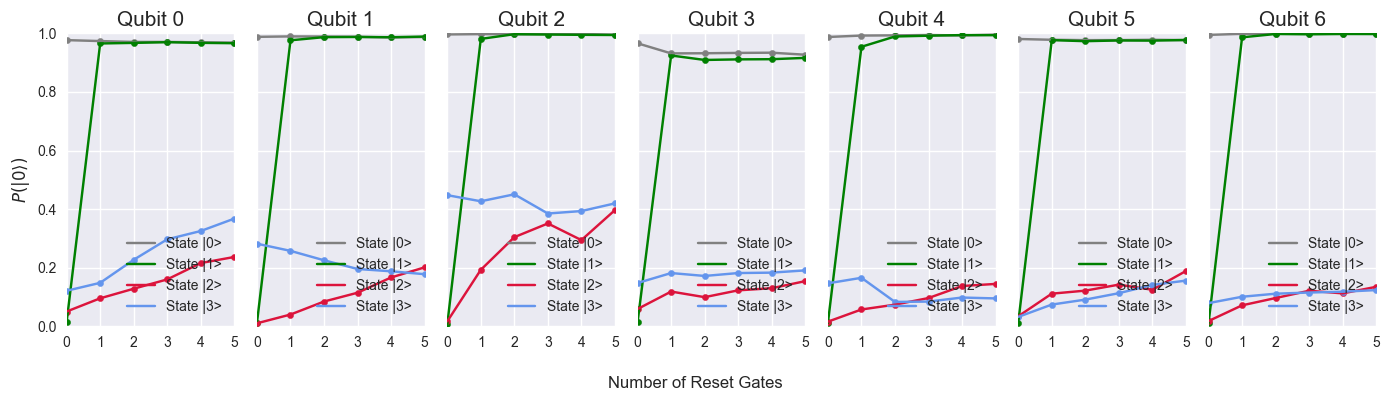

In [31]:
mpl.style.use('seaborn')

fig, axes = plt.subplots(1, num_qubit, figsize = (14, 4), dpi = 100, sharey=True, sharex = True)

fig.supxlabel("Number of Reset Gates", fontsize = 12)

axes[0].set_ylabel(r"$P(|0\rangle)$", fontsize = 12)
for qubit in range(num_qubit):
    for state in range(4):
        if state == 0:
            axes[qubit].set_title(f"Qubit {qubit}", fontsize = 15)
        plt.xlim([0, 5])
        plt.ylim([0, 1.0])
        axes[qubit].plot(num_reset_list, data[state * len(num_reset_list): (state+1) * len(num_reset_list), qubit, 0], label = f"State |{state}>", c = colors[state])
        axes[qubit].scatter(num_reset_list, data[state * len(num_reset_list): (state+1) * len(num_reset_list), qubit, 0], c=colors[state], s = 20)
        plt.xticks(range(6), range(6))
        axes[qubit].legend(loc = 4)
    
plt.tight_layout()
# plt.savefig("./figs/num_reset.pdf")

### Secure Reset

In [10]:
num_reset_list = list(range(6))
shots = 10000

In [ ]:
# job_list = []
# job_id_list = []
# for state in range(4):
#     for num_reset in num_reset_list:
#         job = backend.run(gen_circ(state, num_reset, add_delay = True, add_secure_reset=True), backend, shots=shots, rep_delay = 300e-6, optimization_level=0)
#         job_list.append(job)
#         job_id_list.append(job.job_id())
# job_id_list

In [11]:
# secure_job_id_list = ['633852181ff5691eba8b7593',
#  '6338521ab7c9eb4257c921b6',
#  '6338521cdee3d60fdfb91245',
#  '6338521e537ba3b3f21396c7',
#  '6338522363d5042d7a868f2e',
#  '63385225dee3d6ebfab91246',
#  '633852271ff5696c168b7594',
#  '6338522983172d6477d180bc',
#  '63385230f15a0b3af2d0606e',
#  '633852311ff5690b4d8b7595',
#  '6338523383172d6fc7d180bd',
#  '63385235a146b516581f7172',
#  '6338523a5706bc56e94659a8',
#  '6338523cdee3d6fc09b91248',
#  '6338523eb7c9eb385bc921b8',
#  '63385240a146b51deb1f7173',]
# secure_job_list = [backend.retrieve_job(job_id) for job_id in secure_job_id_list]

In [ ]:
# save_job(secure_job_list, "data/secure_reset.pickle")

In [ ]:
# secure_job_list = load_job("data/secure_reset.pickle")

In [12]:
# secure_data = np.array([[single_qubit_count([job.result().get_counts()], qubit) for qubit in range(num_qubit)] for job in secure_job_list]).reshape((-1, num_qubit, 2))/shots
# save_job(secure_data, "data/secure_reset_data.pickle")

In [ ]:
secure_data = load_job("data/secure_reset_data.pickle")

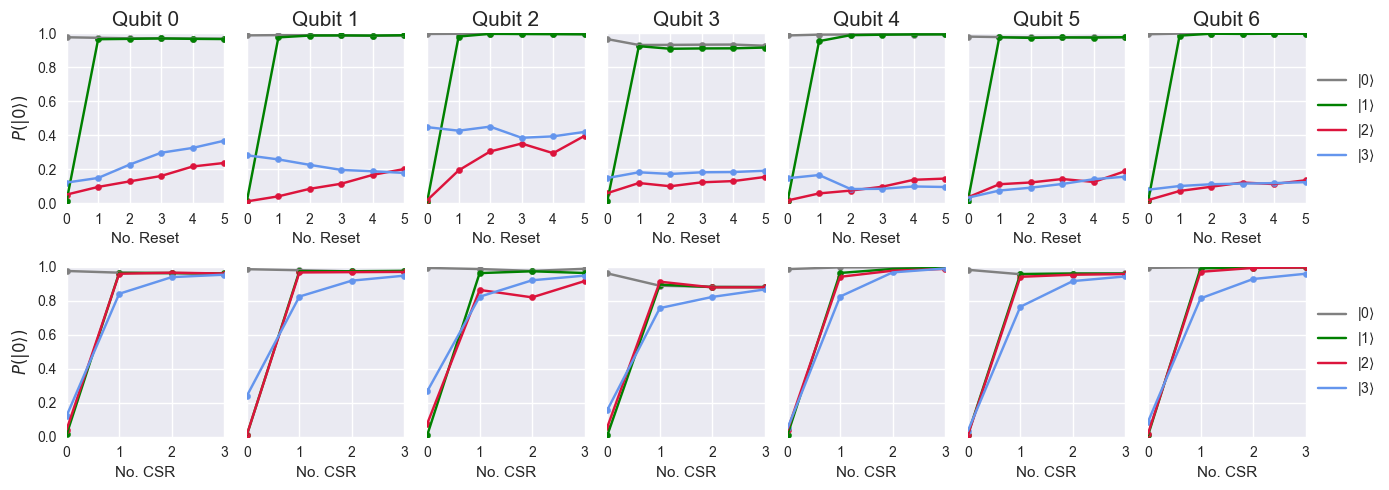

In [15]:
mpl.style.use('seaborn')

fig, axes = plt.subplots(2, num_qubit, figsize = (14, 5), dpi = 100, sharey=True)

num_reset_list = list(range(6))

axes[0][0].set_ylabel(r"$P(|0\rangle)$", fontsize = 12)
for qubit in range(num_qubit):
    for state in range(4):
        if state == 0:
            axes[0][qubit].set_title(f"Qubit {qubit}", fontsize = 15)
        axes[0][qubit].set_xlim([0, 5])
        axes[0][qubit].set_ylim([0, 1.0])
        axes[0][qubit].plot(num_reset_list, data[state * len(num_reset_list): (state+1) * len(num_reset_list), qubit, 0], label = f"|{state}"r"$\rangle$", c = colors[state])
        axes[0][qubit].scatter(num_reset_list, data[state * len(num_reset_list): (state+1) * len(num_reset_list), qubit, 0], c=colors[state], s = 20)
        axes[0][qubit].set_xticks(range(6), range(6))
        axes[0][qubit].set_xlabel("No. Reset")
        # axes[0][qubit].legend(loc = 4)
        if qubit == num_qubit - 1:
            axes[0][qubit].legend(loc='center left', bbox_to_anchor=(1, 0.5))

num_reset_list = list(range(4))

axes[1][0].set_ylabel(r"$P(|0\rangle)$", fontsize = 12)
for qubit in range(num_qubit):
    for state in range(4):
        # if state == 1:
            # axes[1][qubit].set_title(f"Qubit {qubit}", fontsize = 15)
        axes[1][qubit].set_xlim([0, 3])
        axes[1][qubit].set_ylim([0, 1.0])
        axes[1][qubit].plot(num_reset_list, secure_data[state * len(num_reset_list): (state+1) * len(num_reset_list), qubit, 0], label = f"|{state}"r"$\rangle$", c = colors[state])
        axes[1][qubit].scatter(num_reset_list, secure_data[state * len(num_reset_list): (state+1) * len(num_reset_list), qubit, 0], c=colors[state], s = 20)
        axes[1][qubit].set_xticks(range(4), range(4))
        axes[1][qubit].set_xlabel("No. CSR")
        # axes[1][qubit].legend(loc = 4)
        if qubit == num_qubit - 1:
            axes[1][qubit].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    
plt.tight_layout()
# plt.savefig("./figs/num_reset.pdf")